# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

### Загрузка данных

In [1]:
# загрузка библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import lightgbm as lgb
import xgboost as xgb
import category_encoders as ce

from catboost import CatBoostRegressor, Pool
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor

from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OrdinalEncoder, StandardScaler

In [2]:
# чтение файла с данными и сохранение в переменную df
try:
    df = pd.read_csv('C:/Users/79853/Documents/datascience/yandex/k Спринт12/autos.csv')
except:
    df = pd.read_csv('/datasets/autos.csv') # загрузка онлайн

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Price,354369.0,4416.656776,4514.158514,0.0,1050.0,2700.0,6400.0,20000.0
RegistrationYear,354369.0,2004.234448,90.227958,1000.0,1999.0,2003.0,2008.0,9999.0
Power,354369.0,110.094337,189.850405,0.0,69.0,105.0,143.0,20000.0
Kilometer,354369.0,128211.172535,37905.341530,5000.0,125000.0,150000.0,150000.0,150000.0
RegistrationMonth,354369.0,5.714645,3.726421,0.0,3.0,6.0,9.0,12.0
NumberOfPictures,354369.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
PostalCode,354369.0,50508.689087,25783.096248,1067.0,30165.0,49413.0,71083.0,99998.0


In [5]:
columns = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired', 'DateCreated']
for column in columns:
    print("\033[1m" + column + "\033[0;0m")
    print(sorted(df.loc[df[column].notnull(), column].unique()))
    print()

VehicleType
['bus', 'convertible', 'coupe', 'other', 'sedan', 'small', 'suv', 'wagon']

Gearbox
['auto', 'manual']

Model
['100', '145', '147', '156', '159', '1_reihe', '1er', '200', '2_reihe', '300c', '3_reihe', '3er', '4_reihe', '500', '5_reihe', '5er', '601', '6_reihe', '6er', '7er', '80', '850', '90', '900', '9000', '911', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a8', 'a_klasse', 'accord', 'agila', 'alhambra', 'almera', 'altea', 'amarok', 'antara', 'arosa', 'astra', 'auris', 'avensis', 'aveo', 'aygo', 'b_klasse', 'b_max', 'beetle', 'berlingo', 'bora', 'boxster', 'bravo', 'c1', 'c2', 'c3', 'c4', 'c5', 'c_klasse', 'c_max', 'c_reihe', 'caddy', 'calibra', 'captiva', 'carisma', 'carnival', 'cayenne', 'cc', 'ceed', 'charade', 'cherokee', 'citigo', 'civic', 'cl', 'clio', 'clk', 'clubman', 'colt', 'combo', 'cooper', 'cordoba', 'corolla', 'corsa', 'cr_reihe', 'croma', 'crossfire', 'cuore', 'cx_reihe', 'defender', 'delta', 'discovery', 'doblo', 'ducato', 'duster', 'e_klasse', 'elefantino', 'eos'

In [6]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


**Признаки**
- **DateCrawled** — дата скачивания анкеты из базы
- **VehicleType** — тип автомобильного кузова
- **RegistrationYear** — год регистрации автомобиля
- **Gearbox** — тип коробки передач
- **Power** — мощность (л. с.)
- **Model** — модель автомобиля
- **Kilometer** — пробег (км)
- **RegistrationMonth** — месяц регистрации автомобиля
- **FuelType** — тип топлива
- **Brand** — марка автомобиля
- **NotRepaired** — была машина в ремонте или нет
- **DateCreated** — дата создания анкеты
- **NumberOfPictures** — количество фотографий автомобиля
- **PostalCode** — почтовый индекс владельца анкеты (пользователя)
- **LastSeen** — дата последней активности пользователя

**Целевой признак**
- **Price** — цена (евро)

In [7]:
# подсчёт явных дубликатов
df.duplicated().sum()

4

In [8]:
# процент пропущенных значений в датасете
df.isnull().sum() / df.shape[0] * 100

DateCrawled           0.000000
Price                 0.000000
VehicleType          10.579368
RegistrationYear      0.000000
Gearbox               5.596709
Power                 0.000000
Model                 5.560588
Kilometer             0.000000
RegistrationMonth     0.000000
FuelType              9.282697
Brand                 0.000000
NotRepaired          20.079070
DateCreated           0.000000
NumberOfPictures      0.000000
PostalCode            0.000000
LastSeen              0.000000
dtype: float64

In [9]:
sorted(df.loc[df['RegistrationYear'].notnull(), 'RegistrationYear'].unique())

[1000,
 1001,
 1039,
 1111,
 1200,
 1234,
 1253,
 1255,
 1300,
 1400,
 1500,
 1600,
 1602,
 1688,
 1800,
 1910,
 1915,
 1919,
 1920,
 1923,
 1925,
 1927,
 1928,
 1929,
 1930,
 1931,
 1932,
 1933,
 1934,
 1935,
 1936,
 1937,
 1938,
 1940,
 1941,
 1942,
 1943,
 1944,
 1945,
 1946,
 1947,
 1948,
 1949,
 1950,
 1951,
 1952,
 1953,
 1954,
 1955,
 1956,
 1957,
 1958,
 1959,
 1960,
 1961,
 1962,
 1963,
 1964,
 1965,
 1966,
 1967,
 1968,
 1969,
 1970,
 1971,
 1972,
 1973,
 1974,
 1975,
 1976,
 1977,
 1978,
 1979,
 1980,
 1981,
 1982,
 1983,
 1984,
 1985,
 1986,
 1987,
 1988,
 1989,
 1990,
 1991,
 1992,
 1993,
 1994,
 1995,
 1996,
 1997,
 1998,
 1999,
 2000,
 2001,
 2002,
 2003,
 2004,
 2005,
 2006,
 2007,
 2008,
 2009,
 2010,
 2011,
 2012,
 2013,
 2014,
 2015,
 2016,
 2017,
 2018,
 2019,
 2066,
 2200,
 2222,
 2290,
 2500,
 2800,
 2900,
 3000,
 3200,
 3500,
 3700,
 3800,
 4000,
 4100,
 4500,
 4800,
 5000,
 5300,
 5555,
 5600,
 5900,
 5911,
 6000,
 6500,
 7000,
 7100,
 7500,
 7800,
 8000,
 8200,

In [10]:
sorted(df.loc[df['Power'].notnull(), 'Power'].unique())

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


В датасете представлены анкеты за период 2014-2016 гг.

В датасете присутствуют количественные и категориальные переменные. 

В названиях полей нарушен стиль написания - строчные буквы сочетаются с прописными. Необходимо привести названия полей к нижнему регистру и к "змеиному стилю".

Выявлены некорректные значения в следующих полях:

- поле `RegistrationYear` (год регистрации автомобиля) - диапазон [1000, 1800] (верхняя граница интервала взята условно, выделены значения до XX века),  [2066, 9999].
- поле `RegistrationMonth` (месяц регистрации автомобиля) - значение 0.
- поле `Power` (мощность (л. с.)) - значение 0, диапазон [2000, 20000] (нижняя граница интервала взята условно, 2000 л.с. - наивысшая известная мощность автомобиля). 
- поле `Price` (цена (евро)) - значение 0.

Для перечисленных полей необходимо убрать выбросы, т.о., возможно, получится избавиться от некорректных значений.

В полях `VehicleType`, `Gearbox`, `Model`, `FuelType`, `NotRepaired` есть пропуски:
- пропуски в поле `Model` (модель автомобиля) и в поле `NotRepaired` (была машина в ремонте или нет) заполним значением **'unknown'**.
- пропуски в поле `VehicleType` (тип автомобильного кузова) и `Gearbox` (тип коробки передач), `FuelType` (тип топлива) заполним самым часто встречающимся значением (модой) для определенной модели автомобиля.

Выявлено 4 случая явных дубликатов. Их необходимо удалить.

Неявные дубликаты не выявлены.

Поле `DateCreated` (дата создания анкеты) необходимо перевести в формат **datetime**.

Поле `NumberOfPictures` заполнено нулями, его можно удалить. Признаки `PostalCode` (почтовый индекс владельца анкеты (пользователя)), `LastSeen` (дата последней активности пользователя), `DateCrawled` (дата скачивания анкеты из базы), `RegistrationMonth` (месяц регистрации автомобиля) не влияют на целевой признак, их можно удалить.

Для обучения моделей категориальные признаки необходимо преобразовать в численные.

### Предобработка данных

In [11]:
# удаление полей
df = df.drop(['NumberOfPictures', 'PostalCode', 'LastSeen', 'DateCrawled', 'RegistrationMonth'], axis=1)

In [12]:
# приведение названий полей к правильному стилю
df.columns = ['price', 'vehicle_type', 'registration_year', 'gearbox', 'power', 'model', 'kilometer',
              'fuel_type', 'brand', 'not_repaired', 'date_created']

In [13]:
# изменение типа данных c object на datetime64 для поля date_created (дата создания анкеты)
df['date_created'] = pd.to_datetime(df['date_created'], format='%Y-%m-%dT%H:%M:%S')
df['date_created'] = pd.DatetimeIndex(df['date_created']).year  # оставим только год публикации

Оставили только год создания анкеты, т.к. можно предположить, что цены на авто менялись в разные годы: росли или снижались.

Добавим в датасет поле `age` (возраст автомобиля), предположительно, этот признак должен влиять на цену авто.

In [14]:
df['age'] = df['date_created'] - df['registration_year']

In [15]:
df.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,not_repaired,date_created,age
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN,2016,23
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes,2016,5
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN,2016,12
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no,2016,15
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no,2016,8


#### Обработка явных дубликатов

In [16]:
# подсчёт явных дубликатов
df.duplicated().sum()

45037

После исключения нескольких полей, не влияющих на целевой признак, число дубликатов значительно выросло. Этому может быть несколько причин:
- одни и те же анкеты добавлялись на сервис несколько раз (разные значения `DateCreated` (дата создания анкеты)), 
- одни и те же анкеты были скачаны из базы несколько раз (разные значения `DateCrawled` (дата скачивания анкеты из базы)).

Удалим дубликаты из датасета.

In [17]:
# удаление явных дубликатов
df = df.drop_duplicates().reset_index(drop=True)

In [18]:
# проверка на отсутствие дубликатов
df.duplicated().sum()

0

#### Обработка некорректных значений

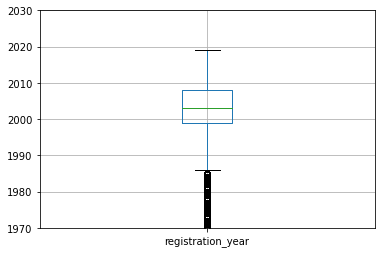

In [19]:
# диаграмма размаха registration_year (год регистрации)
df.boxplot(column='registration_year')
plt.ylim(1970, 2030)
plt.show()

Оставим значения в интервале 1985-2016 гг. (т.к. в датасете представлены анкеты до апреля 2016 года)

In [20]:
df = df.loc[(df.registration_year > 1984) & (df.registration_year < 2017), :]

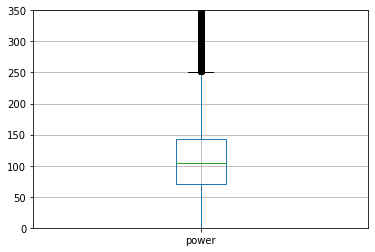

In [21]:
# диаграмма размаха power (мощность (л. с.))
df.boxplot(column='power')
plt.ylim(0, 350)
plt.show()

В поле `power` (мощность (л. с.)) уберем значения выше 250. Также уберем значение 0.

In [22]:
df = df.loc[(df.power < 251) & (df.power > 0), :]

<AxesSubplot:>

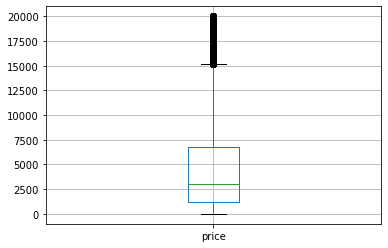

In [23]:
# диаграмма размаха price (цена (евро))
df.boxplot(column='price')

В поле `price` (цена (евро)) уберем значения выше 16000. Также уберем значение 0.

In [24]:
df = df.loc[(df.price < 16001) & (df.price > 0), :]

#### Обработка пропусков

In [25]:
# заполнение пропусков в полях model и not_repaired значением 'unknown'
df.loc[df.model.isnull(), 'model'] = 'unknown'
df.loc[df.not_repaired.isnull(), 'not_repaired'] = 'unknown'

In [26]:
# пропущенные значения
df.isnull().sum()

price                    0
vehicle_type         10205
registration_year        0
gearbox               4947
power                    0
model                    0
kilometer                0
fuel_type            14462
brand                    0
not_repaired             0
date_created             0
age                      0
dtype: int64

Заполним пропуски в поле `vehicle_type` (тип автомобильного кузова) и `gearbox` (тип коробки передач), `fuel_type` (тип топлива) самым часто встречающимся значением для определенной модели автомобиля.

In [27]:
df['gearbox'] = df.groupby(['brand','model'])['gearbox'].transform(lambda x: x.fillna(x.mode()[0]))

In [28]:
df['fuel_type'] = df.groupby(['brand','model'])['fuel_type'].transform(lambda x: x.fillna(x.mode()[0]))

In [29]:
df['vehicle_type'] = df.groupby(['brand','model'])['vehicle_type']\
                       .transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else "unknown"))

In [30]:
df.isnull().sum()

price                0
vehicle_type         0
registration_year    0
gearbox              0
power                0
model                0
kilometer            0
fuel_type            0
brand                0
not_repaired         0
date_created         0
age                  0
dtype: int64

In [31]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
price,239800.0,4305.175992,3861.333969,1.0,1299.0,2990.0,6390.0,16000.0
registration_year,239800.0,2002.985271,5.755705,1985.0,1999.0,2003.0,2007.0,2016.0
power,239800.0,115.527911,44.708417,1.0,75.0,109.0,143.0,250.0
kilometer,239800.0,128904.065888,36025.649159,5000.0,125000.0,150000.0,150000.0,150000.0
date_created,239800.0,2015.999929,0.008419,2015.0,2016.0,2016.0,2016.0,2016.0
age,239800.0,13.014658,5.755733,0.0,9.0,13.0,17.0,31.0


In [32]:
columns = ['vehicle_type', 'gearbox', 'fuel_type', 'not_repaired']
for column in columns:
    print("\033[1m" + column + "\033[0;0m")
    print(sorted(df.loc[df[column].notnull(), column].unique()))
    print()

vehicle_type
['bus', 'convertible', 'coupe', 'other', 'sedan', 'small', 'suv', 'wagon']

gearbox
['auto', 'manual']

fuel_type
['cng', 'electric', 'gasoline', 'hybrid', 'lpg', 'other', 'petrol']

not_repaired
['no', 'unknown', 'yes']



#### Преобразование категориальных признаков

Для обучения моделей категориальные признаки необходимо преобразовать в численные. Для этого используем специальные техники.

Техника **прямого кодирования (OHE)** подходит для преобразования признаков в LinearRegression.

Техника **порядкового кодирования (OrdinalEncoder)** подходит для преобразования признаков в DecisionTree и RandomForest, т.о. эта техника подойдет для моделей градиентного бустинга, которые используют деревья решений в качестве базовых алгоритмов.

Преобразуем данные с помощью двух техник и создадим, соответственно, два новых датасета - **df_ohe** и **df_ordinal**.

In [33]:
# список категориальных переменных в датасете
cat_features = list(df.select_dtypes(include=['object']).columns)
cat_features

['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'not_repaired']

In [34]:
# преобразование с помощью техники OHE
df_ohe = pd.get_dummies(df, columns=cat_features, drop_first=True)
df_ohe.head()

,price,registration_year,power,kilometer,date_created,age,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other,vehicle_type_sedan,...,brand_smart,brand_sonstige_autos,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,not_repaired_unknown,not_repaired_yes
2,9800,2004,163,125000,2016,12,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,1500,2001,75,150000,2016,15,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,3600,2008,69,90000,2016,8,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,650,1995,102,150000,2016,21,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
6,2200,2004,109,150000,2016,12,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [35]:
# преобразование с помощью техник OrdinalEncoder 
ordinal = OrdinalEncoder()

df_ordinal = pd.DataFrame(columns=df.columns)
for column in df.columns:
    if column not in cat_features:
        df_ordinal[column] = df[column]

        
df_ordinal[cat_features] = ordinal.fit_transform(df[cat_features])


df_ordinal.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,not_repaired,date_created,age
2,9800,6.0,2004,0.0,163,117.0,125000,2.0,14.0,1.0,2016,12
3,1500,5.0,2001,1.0,75,116.0,150000,6.0,38.0,0.0,2016,15
4,3600,5.0,2008,1.0,69,101.0,90000,2.0,31.0,0.0,2016,8
5,650,4.0,1995,1.0,102,11.0,150000,6.0,2.0,2.0,2016,21
6,2200,1.0,2004,1.0,109,8.0,150000,6.0,25.0,0.0,2016,12


## Обучение моделей

Обучим несколько моделей градиентного бустинга:
- **LGBMRegressor()**,
- **CatBoostRegressor()**,
- **XGBRegressor()**.

Рассмотрим качество и скорость работы моделей градиентного бустинга по следующему алгоритму:
- обучим модель со значениями гиперпараметров по умолчанию;
- подберем значения нескольких гиперпараметров, которые влияют как на качество, так и на скорость обучения, с помощью GridSearchCV();
- обучим модель с подобранными гиперпараметрами;
- попробуем увеличить скорость работы модели корректировкой гиперпараметров;
- попробуем увеличить скорость работы модели отбором признаков.

Для сравнения также посмотрим на результаты линейной модели **LinearRegression()**.

In [36]:
# функция для разделения датасета на обучающую и тестовую выборки, на признаки (features) и целевой признак (target)
def split_df(data, target):
    # разделение в соотношении 3:1
    df_train, df_test = train_test_split(data, test_size=0.25, random_state=123) 

    train_features = df_train.drop([target], axis=1)
    train_target = df_train[target]

    test_features = df_test.drop([target], axis=1)
    test_target = df_test[target]
    
    
    return train_features, train_target, test_features, test_target

In [37]:
# функция для определения гиперпараметров модели
def grid_search(model, params):
    grid_cv = GridSearchCV(estimator=model, param_grid=params, cv=3, n_jobs=-1, scoring=scorer)
    grid_cv.fit(train_features, train_target)
    print('Гиперпараметры: ', grid_cv.best_params_)
    print('RMSE:', int(-grid_cv.best_score_))
    return grid_cv.best_params_

In [38]:
# функция для обучения модели и определения времени обучения
def fit_predict(model, name, importance_features='all'):
    start_fit_time = time.time()
    model.fit(train_features, train_target)
    fit_time = time.time() - start_fit_time
    
    predictions = model.predict(train_features)
    
    global a
    columns = ['model_name', 'model', 'fit_time_sec', 'RMSE', 'importance_features']
    rows = [[name, model, round(fit_time, 1), int(rmse(train_target, predictions)), importance_features]]
    a = pd.DataFrame(data=rows, columns=columns)

In [39]:
# функция для расчета ошибки RMSE
def rmse(target, predictions):
    return mean_squared_error(target, predictions, squared=False)

In [40]:
# функция оценки для использования в GridSearchCV
scorer = make_scorer(rmse, greater_is_better=False)

In [41]:
# таблица для накопления результатов
columns = ['model_name', 'model', 'fit_time_sec', 'RMSE', 'importance_features']
result_tbl = pd.DataFrame(columns=columns)
result_tbl

,model_name,model,fit_time_sec,RMSE,importance_features


Значения полей таблицы с результатами:
- **model_name** – название модели,
- **model** – конфигурация модели,
- **fit_time_sec** – время обучения модели в секундах,
- **RMSE** – среднеквадратическая ошибка на обучающей выборке,
- **importance_features** – количество важных признаков, отобранных для обучения модели (примеры значений: *all* - признаки не отбирались, *10* - было отобрано 10 признаков)

### LGBMRegressor

In [42]:
train_features, train_target, test_features, test_target = split_df(df_ordinal, 'price')

In [43]:
lgbmreg = LGBMRegressor()

In [44]:
fit_predict(lgbmreg, name='lgbmreg')
result_tbl = pd.concat([result_tbl, a], axis = 0) # добавление показателей в общую таблицу
result_tbl

,model_name,model,fit_time_sec,RMSE,importance_features
0,lgbmreg,LGBMRegressor(),0.4,1418,all


In [45]:
%%time
# подбор гиперпараметров для модели
best = grid_search(lgbmreg, params={'num_leaves': [31, 50, 100],
                                    'max_bin': [255, 355, 555],
                                    'random_state': [123]})

Гиперпараметры:  {'max_bin': 255, 'num_leaves': 100, 'random_state': 123}
RMSE: 1386
Wall time: 15.5 s


In [46]:
# модель с подобранными гиперпараметрами
lgbmreg2 = LGBMRegressor(**best)

In [47]:
fit_predict(lgbmreg2, name='lgbmreg2')
result_tbl = pd.concat([result_tbl, a], axis = 0) # добавление показателей в общую таблицу
result_tbl

,model_name,model,fit_time_sec,RMSE,importance_features
0,lgbmreg,LGBMRegressor(),0.4,1418,all
0,lgbmreg2,"LGBMRegressor(max_bin=255, num_leaves=100, ran...",0.8,1314,all


Уменьшим значения гиперпараметров, чтобы увеличить скорость обучения модели.

In [48]:
lgbmreg3 = LGBMRegressor(num_leaves=31, max_bin=255, random_state=123)

In [49]:
fit_predict(lgbmreg3, name='lgbmreg3')
result_tbl = pd.concat([result_tbl, a], axis = 0) # добавление показателей в общую таблицу
result_tbl

,model_name,model,fit_time_sec,RMSE,importance_features
0,lgbmreg,LGBMRegressor(),0.4,1418,all
0,lgbmreg2,"LGBMRegressor(max_bin=255, num_leaves=100, ran...",0.8,1314,all
0,lgbmreg3,"LGBMRegressor(max_bin=255, random_state=123)",0.5,1418,all


Посмотрим на гистограмму распределения важных признаков для модели **lgbmreg2**.

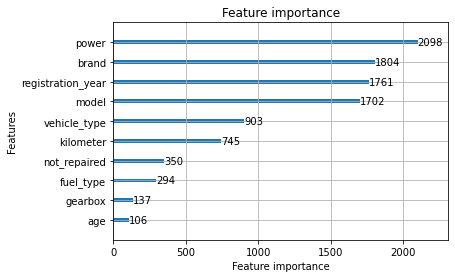

In [50]:
lgb.plot_importance(lgbmreg2);

In [51]:
# таблица признаков в порядке убывания важности
feature_imp = pd.DataFrame({'value':lgbmreg2.feature_importances_,'feature':train_features.columns})\
                .sort_values('value', ascending=False)
feature_imp

,value,feature
3,2098,power
7,1804,brand
1,1761,registration_year
4,1702,model
0,903,vehicle_type
5,745,kilometer
8,350,not_repaired
6,294,fuel_type
2,137,gearbox
10,106,age


Сократим признаки в обучающей выборке до 5 важных признаков.

In [52]:
top_features = 5
train_features = train_features[list(feature_imp['feature'][:top_features])]

In [53]:
fit_predict(lgbmreg2, name='lgbmreg2', importance_features=top_features)
result_tbl = pd.concat([result_tbl, a], axis = 0) # добавление показателей в общую таблицу
result_tbl

,model_name,model,fit_time_sec,RMSE,importance_features
0,lgbmreg,LGBMRegressor(),0.4,1418,all
0,lgbmreg2,"LGBMRegressor(max_bin=255, num_leaves=100, ran...",0.8,1314,all
0,lgbmreg3,"LGBMRegressor(max_bin=255, random_state=123)",0.5,1418,all
0,lgbmreg2,"LGBMRegressor(max_bin=255, num_leaves=100, ran...",0.4,1502,5


**Вывод:**

Модель LGBMRegressor() обучается довольно быстро: менее 1 секунды.

Корректировка гиперпараметров привела к уменьшению времени обучения модели, но при этом увеличилась ошибка. 

Уменьшение количества признаков также привело к уменьшению времени обучения модели и увеличению ошибки.

### CatBoostRegressor

In [54]:
train_features, train_target, test_features, test_target = split_df(df, 'price')

In [55]:
cbreg_cat = CatBoostRegressor(cat_features=cat_features, random_state=123, verbose=0)

In [56]:
fit_predict(cbreg_cat, name='cbreg_cat')
result_tbl = pd.concat([result_tbl, a], axis = 0) # добавление показателей в общую таблицу

In [57]:
result_tbl

,model_name,model,fit_time_sec,RMSE,importance_features
0,lgbmreg,LGBMRegressor(),0.4,1418,all
0,lgbmreg2,"LGBMRegressor(max_bin=255, num_leaves=100, ran...",0.8,1314,all
0,lgbmreg3,"LGBMRegressor(max_bin=255, random_state=123)",0.5,1418,all
0,lgbmreg2,"LGBMRegressor(max_bin=255, num_leaves=100, ran...",0.4,1502,5
0,cbreg_cat,<catboost.core.CatBoostRegressor object at 0x0...,106.7,1320,all


Обучим модель **CatBoostRegressor()** без параметра *cat_features* на данных, преобразованных с помощью алгоритма OrdinalEncoder.

In [58]:
train_features, train_target, test_features, test_target = split_df(df_ordinal, 'price')

In [59]:
cbreg = CatBoostRegressor(verbose=0)

In [60]:
fit_predict(cbreg, name='cbreg')
result_tbl = pd.concat([result_tbl, a], axis = 0) # добавление показателей в общую таблицу

In [61]:
result_tbl

,model_name,model,fit_time_sec,RMSE,importance_features
0,lgbmreg,LGBMRegressor(),0.4,1418,all
0,lgbmreg2,"LGBMRegressor(max_bin=255, num_leaves=100, ran...",0.8,1314,all
0,lgbmreg3,"LGBMRegressor(max_bin=255, random_state=123)",0.5,1418,all
0,lgbmreg2,"LGBMRegressor(max_bin=255, num_leaves=100, ran...",0.4,1502,5
0,cbreg_cat,<catboost.core.CatBoostRegressor object at 0x0...,106.7,1320,all
0,cbreg,<catboost.core.CatBoostRegressor object at 0x0...,14.9,1320,all


Модель обучилась намного быстрее, точность при этом почти не изменилась.

Подберем гиперпараметры для модели CatBoostRegressor().

In [62]:
%%time
best2 = grid_search(cbreg, params={'iterations': [500, 1000],
                                   'depth': [5, 10],
                                   'l2_leaf_reg': [1, 3],
                                   'verbose': [0],
                                   'random_state': [123]})

Гиперпараметры:  {'depth': 10, 'iterations': 1000, 'l2_leaf_reg': 1, 'random_state': 123, 'verbose': 0}
RMSE: 1372
Wall time: 4min 39s


In [63]:
cbreg2 = CatBoostRegressor(**best2)

In [64]:
fit_predict(cbreg2, name='cbreg2')
result_tbl = pd.concat([result_tbl, a], axis = 0) # добавление показателей  в общую таблицу

In [65]:
result_tbl

,model_name,model,fit_time_sec,RMSE,importance_features
0,lgbmreg,LGBMRegressor(),0.4,1418,all
0,lgbmreg2,"LGBMRegressor(max_bin=255, num_leaves=100, ran...",0.8,1314,all
0,lgbmreg3,"LGBMRegressor(max_bin=255, random_state=123)",0.5,1418,all
0,lgbmreg2,"LGBMRegressor(max_bin=255, num_leaves=100, ran...",0.4,1502,5
0,cbreg_cat,<catboost.core.CatBoostRegressor object at 0x0...,106.7,1320,all
0,cbreg,<catboost.core.CatBoostRegressor object at 0x0...,14.9,1320,all
0,cbreg2,<catboost.core.CatBoostRegressor object at 0x0...,34.3,1282,all


Уменьшим значения гиперпараметров *depth* и *iterations*, чтобы увеличить скорость обучения модели.

In [66]:
cbreg3 = CatBoostRegressor(iterations=500, depth=5, l2_leaf_reg=1, random_state=123, verbose=0)

In [67]:
fit_predict(cbreg3, name='cbreg3')
result_tbl = pd.concat([result_tbl, a], axis = 0) # добавление показателей в общую таблицу

In [68]:
result_tbl

,model_name,model,fit_time_sec,RMSE,importance_features
0,lgbmreg,LGBMRegressor(),0.4,1418,all
0,lgbmreg2,"LGBMRegressor(max_bin=255, num_leaves=100, ran...",0.8,1314,all
0,lgbmreg3,"LGBMRegressor(max_bin=255, random_state=123)",0.5,1418,all
0,lgbmreg2,"LGBMRegressor(max_bin=255, num_leaves=100, ran...",0.4,1502,5
0,cbreg_cat,<catboost.core.CatBoostRegressor object at 0x0...,106.7,1320,all
0,cbreg,<catboost.core.CatBoostRegressor object at 0x0...,14.9,1320,all
0,cbreg2,<catboost.core.CatBoostRegressor object at 0x0...,34.3,1282,all
0,cbreg3,<catboost.core.CatBoostRegressor object at 0x0...,5.6,1508,all


Посмотрим на перечень важных признаков для модели **CatBoostRegressor(iterations=1000, depth=10, l2_leaf_reg=1, random_state=123)**.

In [69]:
train_dataset = Pool(train_features, train_target)
feature_importance = cbreg2.get_feature_importance(train_dataset, prettified=True)
feature_importance

,Feature Id,Importances
0,power,21.499712
1,registration_year,17.769036
2,age,16.473219
3,brand,13.940612
4,kilometer,9.858870
5,vehicle_type,8.068184
6,model,4.976260
7,not_repaired,3.901573
8,fuel_type,2.633149
9,gearbox,0.877484


Обучим модель с использованием 6 самых важных признаков.

In [70]:
top_features = 6
train_features = train_features[list(feature_importance['Feature Id'])[:top_features]]

In [71]:
fit_predict(cbreg2, name='cbreg2', importance_features=top_features)
result_tbl = pd.concat([result_tbl, a], axis = 0) # добавление показателей в общую таблицу

In [72]:
result_tbl

,model_name,model,fit_time_sec,RMSE,importance_features
0,lgbmreg,LGBMRegressor(),0.4,1418,all
0,lgbmreg2,"LGBMRegressor(max_bin=255, num_leaves=100, ran...",0.8,1314,all
0,lgbmreg3,"LGBMRegressor(max_bin=255, random_state=123)",0.5,1418,all
0,lgbmreg2,"LGBMRegressor(max_bin=255, num_leaves=100, ran...",0.4,1502,5
0,cbreg_cat,<catboost.core.CatBoostRegressor object at 0x0...,106.7,1320,all
0,cbreg,<catboost.core.CatBoostRegressor object at 0x0...,14.9,1320,all
0,cbreg2,<catboost.core.CatBoostRegressor object at 0x0...,34.3,1282,all
0,cbreg3,<catboost.core.CatBoostRegressor object at 0x0...,5.6,1508,all
0,cbreg2,<catboost.core.CatBoostRegressor object at 0x0...,24.2,1417,6


**Вывод:**

Модель CatBoostRegressor() обучается довольно медленно, если обрабатывать категориальные признаки внутри модели с помощью гиперпараметра *cat_features*. Если же категориальные признаки обработать заранее, скорость обучения модели увеличивается примерно в 10 раз. Время обучения модели составило 6-40 секунд.

Корректировка гиперпараметров привела к значительному уменьшению времени обучения модели, но при этом увеличилась ошибка. 

Уменьшение количества признаков привело к незначительному уменьшению времени обучения модели и увеличению ошибки.

### XGBRegressor

In [73]:
train_features, train_target, test_features, test_target = split_df(df_ordinal, 'price')

In [74]:
xgbreg = XGBRegressor() 

In [75]:
fit_predict(xgbreg, name='xgbreg')
result_tbl = pd.concat([result_tbl, a], axis = 0) # добавление показателей в общую таблицу
result_tbl

,model_name,model,fit_time_sec,RMSE,importance_features
0,lgbmreg,LGBMRegressor(),0.4,1418,all
0,lgbmreg2,"LGBMRegressor(max_bin=255, num_leaves=100, ran...",0.8,1314,all
0,lgbmreg3,"LGBMRegressor(max_bin=255, random_state=123)",0.5,1418,all
0,lgbmreg2,"LGBMRegressor(max_bin=255, num_leaves=100, ran...",0.4,1502,5
0,cbreg_cat,<catboost.core.CatBoostRegressor object at 0x0...,106.7,1320,all
0,cbreg,<catboost.core.CatBoostRegressor object at 0x0...,14.9,1320,all
0,cbreg2,<catboost.core.CatBoostRegressor object at 0x0...,34.3,1282,all
0,cbreg3,<catboost.core.CatBoostRegressor object at 0x0...,5.6,1508,all
0,cbreg2,<catboost.core.CatBoostRegressor object at 0x0...,24.2,1417,6
0,xgbreg,"XGBRegressor(base_score=0.5, booster='gbtree',...",4.1,1301,all


In [76]:
%%time
best3 = grid_search(xgbreg, params={'max_depth': [3, 10, 15],
                                    'random_state': [123]})

Гиперпараметры:  {'max_depth': 10, 'random_state': 123}
RMSE: 1387
Wall time: 55.5 s


In [77]:
xgbreg2 = XGBRegressor(**best3)

In [78]:
fit_predict(xgbreg2, name='xgbreg2')
result_tbl = pd.concat([result_tbl, a], axis = 0) # добавление показателей в общую таблицу
result_tbl

,model_name,model,fit_time_sec,RMSE,importance_features
0,lgbmreg,LGBMRegressor(),0.4,1418,all
0,lgbmreg2,"LGBMRegressor(max_bin=255, num_leaves=100, ran...",0.8,1314,all
0,lgbmreg3,"LGBMRegressor(max_bin=255, random_state=123)",0.5,1418,all
0,lgbmreg2,"LGBMRegressor(max_bin=255, num_leaves=100, ran...",0.4,1502,5
0,cbreg_cat,<catboost.core.CatBoostRegressor object at 0x0...,106.7,1320,all
0,cbreg,<catboost.core.CatBoostRegressor object at 0x0...,14.9,1320,all
0,cbreg2,<catboost.core.CatBoostRegressor object at 0x0...,34.3,1282,all
0,cbreg3,<catboost.core.CatBoostRegressor object at 0x0...,5.6,1508,all
0,cbreg2,<catboost.core.CatBoostRegressor object at 0x0...,24.2,1417,6
0,xgbreg,"XGBRegressor(base_score=0.5, booster='gbtree',...",4.1,1301,all


Уменьшим значение гиперпараметра *max_depth*.

In [79]:
xgbreg3 = XGBRegressor(max_depth=3, random_state=123)

In [80]:
fit_predict(xgbreg3, name='xgbreg3')
result_tbl = pd.concat([result_tbl, a], axis = 0) # добавление показателей в общую таблицу
result_tbl

,model_name,model,fit_time_sec,RMSE,importance_features
0,lgbmreg,LGBMRegressor(),0.4,1418,all
0,lgbmreg2,"LGBMRegressor(max_bin=255, num_leaves=100, ran...",0.8,1314,all
0,lgbmreg3,"LGBMRegressor(max_bin=255, random_state=123)",0.5,1418,all
0,lgbmreg2,"LGBMRegressor(max_bin=255, num_leaves=100, ran...",0.4,1502,5
0,cbreg_cat,<catboost.core.CatBoostRegressor object at 0x0...,106.7,1320,all
0,cbreg,<catboost.core.CatBoostRegressor object at 0x0...,14.9,1320,all
0,cbreg2,<catboost.core.CatBoostRegressor object at 0x0...,34.3,1282,all
0,cbreg3,<catboost.core.CatBoostRegressor object at 0x0...,5.6,1508,all
0,cbreg2,<catboost.core.CatBoostRegressor object at 0x0...,24.2,1417,6
0,xgbreg,"XGBRegressor(base_score=0.5, booster='gbtree',...",4.1,1301,all


Посмотрим на перечень важных признаков.

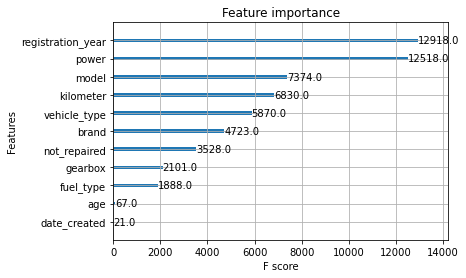

In [81]:
xgb.plot_importance(xgbreg2); 

In [82]:
# функция для вывода таблицы с признаками в порядке убывания важности
def xgb_feature_select(model):
    feature_important = model.get_booster().get_score()

    feature_imp = pd.DataFrame(columns=['value', 'feature'])
    feature_imp['value'] = list(feature_important.values())
    feature_imp['feature'] = list(feature_important.keys())
    feature_imp = feature_imp.sort_values('value', ascending=False)
    return feature_imp

In [83]:
feature_imp = xgb_feature_select(xgbreg2)
feature_imp

,value,feature
1,12918.0,registration_year
3,12518.0,power
4,7374.0,model
5,6830.0,kilometer
0,5870.0,vehicle_type
7,4723.0,brand
8,3528.0,not_repaired
2,2101.0,gearbox
6,1888.0,fuel_type
10,67.0,age


Обучим модель с использованием 5 самых важных признаков.

In [84]:
top_features = 5
train_features = train_features[list(feature_imp['feature'][:top_features])]

In [85]:
fit_predict(xgbreg2, name='xgbreg2', importance_features=top_features)
result_tbl = pd.concat([result_tbl, a], axis = 0) # добавление показателей в общую таблицу
result_tbl

,model_name,model,fit_time_sec,RMSE,importance_features
0,lgbmreg,LGBMRegressor(),0.4,1418,all
0,lgbmreg2,"LGBMRegressor(max_bin=255, num_leaves=100, ran...",0.8,1314,all
0,lgbmreg3,"LGBMRegressor(max_bin=255, random_state=123)",0.5,1418,all
0,lgbmreg2,"LGBMRegressor(max_bin=255, num_leaves=100, ran...",0.4,1502,5
0,cbreg_cat,<catboost.core.CatBoostRegressor object at 0x0...,106.7,1320,all
0,cbreg,<catboost.core.CatBoostRegressor object at 0x0...,14.9,1320,all
0,cbreg2,<catboost.core.CatBoostRegressor object at 0x0...,34.3,1282,all
0,cbreg3,<catboost.core.CatBoostRegressor object at 0x0...,5.6,1508,all
0,cbreg2,<catboost.core.CatBoostRegressor object at 0x0...,24.2,1417,6
0,xgbreg,"XGBRegressor(base_score=0.5, booster='gbtree',...",4.1,1301,all


**Вывод:**

Модель XGBRegressor() показала наименьшее значение ошибки RMSE среди других моделей, которые были исследованы выше.

Корректировка гиперпараметров привела к уменьшению времени обучения модели (примерно в 3 раза), но при этом значительно увеличилась ошибка. 

Уменьшение количества признаков привело к уменьшению времени обучения модели, но при этом ошибка увеличилась.

### LinearRegression

In [86]:
train_features, train_target, test_features, test_target = split_df(df_ohe, 'price')

In [87]:
linear = LinearRegression()

In [88]:
fit_predict(linear, name='linear')
result_tbl = pd.concat([result_tbl, a], axis = 0) # добавление показателей в общую таблицу
result_tbl

,model_name,model,fit_time_sec,RMSE,importance_features
0,lgbmreg,LGBMRegressor(),0.4,1418,all
0,lgbmreg2,"LGBMRegressor(max_bin=255, num_leaves=100, ran...",0.8,1314,all
0,lgbmreg3,"LGBMRegressor(max_bin=255, random_state=123)",0.5,1418,all
0,lgbmreg2,"LGBMRegressor(max_bin=255, num_leaves=100, ran...",0.4,1502,5
0,cbreg_cat,<catboost.core.CatBoostRegressor object at 0x0...,106.7,1320,all
0,cbreg,<catboost.core.CatBoostRegressor object at 0x0...,14.9,1320,all
0,cbreg2,<catboost.core.CatBoostRegressor object at 0x0...,34.3,1282,all
0,cbreg3,<catboost.core.CatBoostRegressor object at 0x0...,5.6,1508,all
0,cbreg2,<catboost.core.CatBoostRegressor object at 0x0...,24.2,1417,6
0,xgbreg,"XGBRegressor(base_score=0.5, booster='gbtree',...",4.1,1301,all


**Вывод:**

Модель линейной регрессии показала более высокую ошибку, чем модели градиентного бустинга. 

## Анализ моделей

Отсортируем таблицу с результатами по величине ошибки RMSE. Посмотрим на соотношение времени выполнения и величины ошибки RMSE. Выберем лучшую модель.

In [89]:
result_tbl.sort_values('RMSE')

,model_name,model,fit_time_sec,RMSE,importance_features
0,xgbreg2,"XGBRegressor(base_score=0.5, booster='gbtree',...",8.2,1033,all
0,xgbreg2,"XGBRegressor(base_score=0.5, booster='gbtree',...",4.2,1162,5
0,cbreg2,<catboost.core.CatBoostRegressor object at 0x0...,34.3,1282,all
0,xgbreg,"XGBRegressor(base_score=0.5, booster='gbtree',...",4.1,1301,all
0,lgbmreg2,"LGBMRegressor(max_bin=255, num_leaves=100, ran...",0.8,1314,all
0,cbreg_cat,<catboost.core.CatBoostRegressor object at 0x0...,106.7,1320,all
0,cbreg,<catboost.core.CatBoostRegressor object at 0x0...,14.9,1320,all
0,cbreg2,<catboost.core.CatBoostRegressor object at 0x0...,24.2,1417,6
0,lgbmreg,LGBMRegressor(),0.4,1418,all
0,lgbmreg3,"LGBMRegressor(max_bin=255, random_state=123)",0.5,1418,all


Протестируем модель **xgbreg2**. Посчитаем время, затраченное на получение предсказаний.
- xgbreg2 = XGBRegressor(max_depth=10, random_state=123)

In [90]:
# таблица для накопления результатов тестирования
columns = ['model_name', 'model', 'predict_time_sec', 'RMSE']
result_tbl2 = pd.DataFrame(columns=columns)
result_tbl2

,model_name,model,predict_time_sec,RMSE


Значения полей таблицы с результатами:
- **model_name** – название модели,
- **model** – конфигурация модели,
- **predict_time_sec** – время, за которое получены предсказания, в секундах,
- **RMSE** – среднеквадратическая ошибка на тестовой выборке.

In [91]:
# функция для тестирования модели и расчета времени, за которое получены предсказания
def test(model, name):
    model.fit(train_features, train_target)
    
    start_predict_time = time.time()
    predictions = model.predict(test_features)
    predict_time = time.time() - start_predict_time
    
    global a
    columns = ['model_name', 'model', 'predict_time_sec', 'RMSE']
    rows = [[name, model, round(predict_time, 1), int(rmse(test_target, predictions))]]
    a = pd.DataFrame(data=rows, columns=columns)

In [92]:
train_features, train_target, test_features, test_target = split_df(df_ordinal, 'price')

In [93]:
test(xgbreg2, name='xgbreg2')
result_tbl2 = pd.concat([result_tbl2, a], axis = 0) # добавление показателей в общую таблицу

In [95]:
print("\033[1m" + "Результаты выбранной модели на этапе обучения" + "\033[0;0m")
result_tbl.loc[(result_tbl.model_name == 'xgbreg2') & (result_tbl.importance_features == 'all')]

Результаты выбранной модели на этапе обучения


,model_name,model,fit_time_sec,RMSE,importance_features
0,xgbreg2,"XGBRegressor(base_score=0.5, booster='gbtree',...",8.2,1033,all


In [96]:
print("\033[1m" + "Результаты выбранной модели на этапе тестирования" + "\033[0;0m")
result_tbl2

Результаты выбранной модели на этапе тестирования


,model_name,model,predict_time_sec,RMSE
0,xgbreg2,"XGBRegressor(base_score=0.5, booster='gbtree',...",0.0,1365


## Общий вывод

В ходе проекта были исследованы исторические данные сервиса по продаже автомобилей: технические характеристики, комплектации и цены автомобилей, - с целью построения модели для определения стоимости.

На этапе **подготовки данных** были удалены поля, не влияющие на целевой признак, выявлены и удалены явные дубликаты, обработаны пропуски и некорректные значения в данных, категориальные признаки преобразованы в численные при помощи техник OHE и OrdinalEncoder.

В **п.2** было обучено три модели градиентного бустинга: 
- **LGBMRegressor()**,
- **CatBoostRegressor()**,
- **XGBRegressor()**.

Было рассмотрено качество и скорость работы моделей градиентного бустинга по следующему алгоритму:
- обучена модель со значениями гиперпараметров по умолчанию;
- подобраны значения нескольких гиперпараметров, которые влияют как на качество, так и на скорость обучения, с помощью GridSearchCV();
- обучена модель с подобранными гиперпараметрами;
- увеличена скорость работы модели корректировкой гиперпараметров;
- увеличена скорость работы модели отбором признаков.

Для сравнения также была обучена модель линейной регрессии **LinearRegression()**.

Лучшие результаты показала модель **XGBRegressor(max_depth=10, random_state=123)**:
- время обучения - 8 секунд,
- время предсказания - 0 секунд,
- RMSE на обучающей выборке - 1033,
- RMSE на тестовой выборке - 1365.